In [1]:
import pandas as pd
import numpy as np

In [2]:
# leer la base de datos de comentarios del bcp
bcp = pd.read_csv("recursos/entrenamiento/comentarios.csv")

In [3]:
bcp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13290 entries, 0 to 13289
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   score    13290 non-null  int64 
 1   comment  13290 non-null  object
dtypes: int64(1), object(1)
memory usage: 207.8+ KB


In [4]:
bcp.head(10)

,score,comment
0,5,totalmente satisfecho x q resolvieron mi cons...
1,5,la atencion fue rapida y clara
2,4,me atendieron bien
3,5,fue muy rapido la atencion
4,5,por que me atendieron muy amablemente con buen...
5,4,me atendieron bien con mucha atencion
6,5,la atencion de las señoritas de la entrada fue...
7,5,porque hay varios cajerosas es una agencia rel...
8,5,buena atencion
9,4,la atencion fue rapida y no toma mucho tiempo


In [5]:
# leer el archivo de comentarios limpios
temp_df = pd.read_csv("recursos/entrenamiento/comentarios_limpios.csv",
                     header = 0,
                     names = ["texto_limpio"])

In [6]:
# Almacenando los comentarios limpios para su posterior lectura en W2V
np.savetxt("recursos/entrenamiento/W2V_input.txt", 
           temp_df["texto_limpio"].values,
           fmt="%s",
           encoding="utf-8")

## 2. Word2Vec

In [7]:
from gensim.models import word2vec

In [8]:
corpus = word2vec.Text8Corpus("recursos/entrenamiento/W2V_input.txt")

In [9]:
# entrenar un modelo W2V para la extracción de característicsa
W2V_SIZE = 100
modelo = word2vec.Word2Vec(corpus, size=W2V_SIZE, min_count=2)

In [10]:
modelo.wv.vocab

{'totalmente': <gensim.models.keyedvectors.Vocab at 0x18ae8b5a760>,
 'satisfecho': <gensim.models.keyedvectors.Vocab at 0x18ae8b5a850>,
 'resolvieron': <gensim.models.keyedvectors.Vocab at 0x18ae8b5a8b0>,
 'consulta': <gensim.models.keyedvectors.Vocab at 0x18ae8b5a970>,
 'atencion': <gensim.models.keyedvectors.Vocab at 0x18ae8b5a9d0>,
 'mis': <gensim.models.keyedvectors.Vocab at 0x18ae8b5a730>,
 'dudas': <gensim.models.keyedvectors.Vocab at 0x18ae8b5aa60>,
 'rapida': <gensim.models.keyedvectors.Vocab at 0x18ae8b5aac0>,
 'clara': <gensim.models.keyedvectors.Vocab at 0x18ae8b5aaf0>,
 'atendieron': <gensim.models.keyedvectors.Vocab at 0x18ae8b5ab50>,
 'rapido': <gensim.models.keyedvectors.Vocab at 0x18ae8b5a910>,
 'amablemente': <gensim.models.keyedvectors.Vocab at 0x18ae8b5a940>,
 'actitud': <gensim.models.keyedvectors.Vocab at 0x18ae8b5ac10>,
 'plataforma': <gensim.models.keyedvectors.Vocab at 0x18ae8b5ac40>,
 'cajero': <gensim.models.keyedvectors.Vocab at 0x18ae8b5aca0>,
 'señoritas': 

#### Función para obtener vector promedio

In [11]:
#document => Texto. Ejem: "Hola Mundo"
def getFV(document, modelo):
    
    words=document.split()
    s= np.array([0]*W2V_SIZE)
    k=1
    for w in words:
        if w in modelo.wv.vocab:
            s=s+modelo[w]          #vecrtores
            k=k+1                  #k es un contador
    
    return s/k      #para promediar

In [12]:
def polaridad(x):
    if(x>=4): return 1
    elif(x==3): return 0
    else: return -1

In [13]:
# almacenar los vectores característicos
bcp["vector"] = bcp["comment"].apply(lambda x: getFV(x, modelo))

<ipython-input-11-5079b303dce2>:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  s=s+modelo[w]


In [14]:
# almacenar el score simple
bcp["simple_score"] = bcp["score"].apply(lambda x: polaridad(x))

In [15]:
bcp.head()

,score,comment,vector,simple_score
0,5,totalmente satisfecho x q resolvieron mi cons...,"[0.3953956365585327, -0.024126147269271314, 0....",1
1,5,la atencion fue rapida y clara,"[0.3459749147295952, -0.040719631128013134, 0....",1
2,4,me atendieron bien,"[0.2560012638568878, -0.027857467532157898, 0....",1
3,5,fue muy rapido la atencion,"[0.3107350567976634, -0.0362476222217083, 0.23...",1
4,5,por que me atendieron muy amablemente con buen...,"[0.3604387293259303, -0.02321077836677432, 0.2...",1


In [17]:
# definir las matrices de datos
X = np.stack(bcp["vector"].values)  #cuando es lista  de listas aplicar np.stack
y = bcp["simple_score"].values

X.shape, y.shape

((13290, 100), (13290,))

In [18]:
# TRAIN - TEST SPLIT
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
       X, y, test_size=0.25, random_state=42)

## 3. Entrenar el clasificador de polaridad: SVM

In [19]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [24]:
# definir el espacio de búsqueda
params = {'kernel': ('linear', 'rbf'),
          'C': [1, 10, 100],
          'gamma': [0.1, 0.001, 0.0001, 0.00001]}

In [25]:
# buscar los parámetros óptimos
clasificador = svm.SVC()
clasificador = GridSearchCV(clasificador, params, cv=5)    #cv:cross validation
clasificador.fit(X, y)

In [26]:
# ver los parámetros seleccionados
clasificador.best_params_
#{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

In [20]:
# entrenar el modelo con los parámetros óptimos
clasificador = svm.SVC(C=100, gamma=0.1, kernel="rbf")
clasificador.fit(X_train, y_train)

SVC(C=100, gamma=0.1)

In [21]:
# Realizar las predicciones
y_pred = clasificador.predict(X_test)
y_pred

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

In [22]:
# evaluar el clasificador
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.53      0.32      0.40       665
           0       0.56      0.70      0.62      1000
           1       0.83      0.83      0.83      1658

    accuracy                           0.69      3323
   macro avg       0.64      0.62      0.62      3323
weighted avg       0.69      0.69      0.68      3323



In [23]:
clasificador.predict(getFV("buena atencion", modelo).reshape(1,-1))

<ipython-input-11-5079b303dce2>:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  s=s+modelo[w]


array([1], dtype=int64)

4.- Predecir la polaridad de los tweets

In [34]:
# cargar los tweets limpios
data_original = pd.read_csv("recursos/prediccion/bd_tweets.csv", 
                   header = 0)
data_original

,fecha,texto
0,2020-03-03 23:04:32,Este fiscal está llenando la cárcel d prisione...
1,2020-03-03 22:53:53,Requisitos indispensables para ser Ministro de...
2,2020-03-03 22:46:57,Pedirle a la ciudadania ser PREVENIDA contra e...
3,2020-03-03 22:41:24,Gracias a #Vizcarra la policía tiene harto tra...
4,2020-03-03 20:01:31,Parece que si seguimos con #Vizcarra sólo crec...
...,...,...
18347,2020-06-25 00:31:18,#Vizcarra solo quiere subir en las encuestas. ...
18348,2020-06-25 00:27:52,"#vizcarra ""Por que te quiero abrazar mañana, m..."
18349,2020-06-25 00:27:49,Cuando llegue las 47 horas con 50 segundo aluc...
18350,2020-06-25 00:26:18,38 mil millones de dólares en empréstitos obtu...


In [35]:
# cargar los tweets limpios
data = pd.read_csv("recursos/prediccion/bd_tweets_limpios.csv", 
                   header = 0, 
                   names = ["texto_limpio"])
data

,texto_limpio
0,este fiscal llenando carcel prisiones preventi...
1,requisitos indispensables ministro vizcarra te...
2,pedirle ciudadania prevenida coronavirus pais ...
3,gracias vizcarra policia harto
4,parece seguimos vizcarra crecera gasto estado ...
...,...
18347,vizcarra subir encuestas vizcarra problema viz...
18348,vizcarra por quiero abrazar mañana distancio q...
18349,cuando llegue horas alucino gente gritando bal...
18350,mil millones dolares emprestitos obtuvo gobier...


In [36]:
# guardar su representación vectorial
data["vector"] = data["texto_limpio"].apply(lambda x: getFV(x, modelo))

<ipython-input-11-5079b303dce2>:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  s=s+modelo[w]


In [37]:
# almacenar los vectores en una matriz para realizar las predicciones
tweets_matriz = np.stack(data["vector"].values)
tweets_matriz.shape

(18352, 100)

In [38]:
# realizar las predicciones de polaridad de los tweets
data["polaridad"] = clasificador.predict(tweets_matriz)     

In [39]:
data.loc[:, ["texto_limpio", "polaridad"]]

,texto_limpio,polaridad
0,este fiscal llenando carcel prisiones preventi...,0
1,requisitos indispensables ministro vizcarra te...,0
2,pedirle ciudadania prevenida coronavirus pais ...,0
3,gracias vizcarra policia harto,0
4,parece seguimos vizcarra crecera gasto estado ...,0
...,...,...
18347,vizcarra subir encuestas vizcarra problema viz...,0
18348,vizcarra por quiero abrazar mañana distancio q...,0
18349,cuando llegue horas alucino gente gritando bal...,0
18350,mil millones dolares emprestitos obtuvo gobier...,0


In [40]:
# frecuencia de las polaridades
data["polaridad"].value_counts()

 0    17268
 1      610
-1      474
Name: polaridad, dtype: int64

In [47]:
# inspeccionar los resultados de la clasificación
for x in data_original[data["polaridad"] == 1]["texto"].sample(5):
    print(x)
    print("---------")

Ahora mismo la maratón del Dr. Huerta @drhuerta resolviendo todas las dudas sobre el #COVIDー19  en RPP 89.7fm  #YoMeQuedoEnCasa #quedateencasa #CoronavirusPerú
---------
Me gusta ese hashtag y para tu información no soy Fujimorista ni Aprista, ni nunca lo fuí de ambos, qué ridícula idea, el que crítica a #Vizcarra, necesariamente tiene que ser Fujimorista o Aprista?
---------
Ojalá y lo lean y escuchen Doctor. Yo ya tengo serias dudas sobre las intenciones de #Vizcarra .A veces pienso que está mas favor del caos que de cualquier solución inteligente
---------
Con PLOMO en sangre NIÑOS DE PASCO, son víctimas de un delito de lesa humanidad, causado por acción de mineras e inacción del gobierno. Si no hay pronta atención ni justicia hay que demandar ante prensa y cortes internacionales!! #Vizcarra Newton College 

https://twitter.com/chilcanodepsico/status/1236713014734159872?s=21 …https://twitter.com/chilcanodepsico/status/1236713014734159872 …
---------
NOS GOBIERNAN UNA BANDA DE DELINC

In [48]:
# guardar las polaridades de los tweets para su posterior analisis
np.savetxt("recursos/prediccion/bd_tweets_polaridad.csv",
           data["polaridad"].values,
           header = "polaridad",
           fmt="%s", 
           encoding="utf-8")

In [44]:
# word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [45]:
comment_words = ""
for x in data[data["polaridad"]==1]["texto_limpio"]:
    comment_words += " " + x 

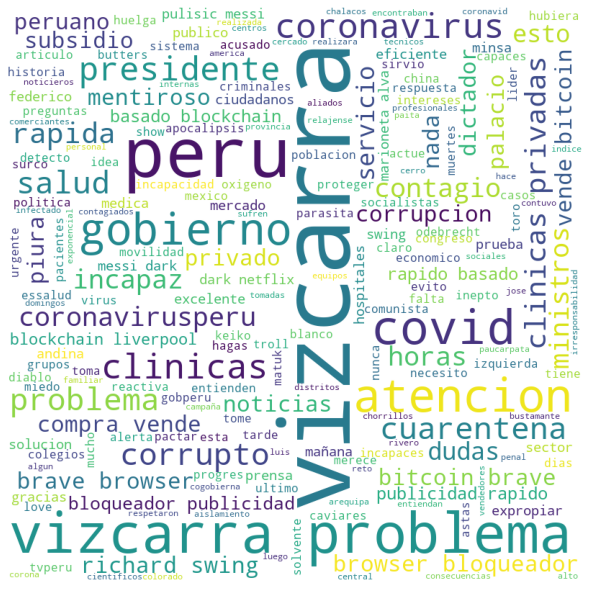

In [46]:
# word cloud por cluster
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                #stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 